# Выпускной проект - Промышленность

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача этого проекта — построить модель, которая будет её предсказывать.

Для выполнения этой задачи, в рамках этого проекта будут реализованы следующие операции:
1. Загрузка и предобработка данных
2. Исследовательский анализ данных
3. Создание дополнительных признаков 
4. Объединение данных в общий датасет
5. Исследовательский анализ объединенного датасета
6. Построение пайплайнов для подбора гиперпараметров моделей
7. Обучение моделей в режиме кросс-валидации
8. Тестирование качества лучшей модели

Требование Заказчика по качеству модели - обеспечить ошибку MAE не выше 6,8 единиц целевого признака. 

## Импорт библиотек и функций

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q

In [2]:
#базовые
import pandas as pd
import numpy as np
# отключение ошибок
import warnings
# графики
import seaborn as sns
import matplotlib.pyplot as plt
#анализ корреляции Phi_K 
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
# класс для работы с пропусками
from sklearn.impute import SimpleImputer
# преобразование данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# Модели
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
# Метрики
from sklearn.metrics import mean_absolute_error
# Инструменты подбора гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
# пайплайны
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#проверка адекватности модели
from sklearn.dummy import DummyRegressor

RANDOM_STATE = 280725

In [3]:
#функция первичного анализа данных
def data_report(df, show_info=True):
    temp = df.copy() 
    col_list = temp.columns
    print('='* 90)
    if show_info == True:
        print(temp.info())
#Поиск нулевых значений
    counter = 0
    for column in col_list:
        if (temp[temp[column] == 0][column].count() > 0) | (
            temp[temp[column] == ' '][column].count() > 0):
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пустыми и нулевыми значениями: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пустыми и нулевыми значениями:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во значений":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if (temp[temp[column] == 0][column].count() > 0) | (
               temp[temp[column] == ' '][column].count() > 0):
                print(f'{column :<40}'
                      f'{temp[temp[column] == 0][column].count():<25}'
                      f'{temp[temp[column] == 0][column].count()/len(temp):.2%}')                
#Поиск пропусков
    counter = 0
    for column in col_list:
        if temp[column].isna().sum() > 0:
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пропусками: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пропусками:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во пропусков":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if temp[column].isna().sum() > 0:
                print(f'{column :<40}'
                      f'{temp[column].isna().sum():<25}'
                      f'{temp[column].isna().mean():.2%}')                
#Поиск явных дубликатов
    duplicates = temp.duplicated().sum()
    print('='* 90)
    print(f'Количество дубликатов по строкам: {duplicates}')
    print('='* 90)
    if duplicates > 0:
        print('Дублированные строки:')
        print('-'* 90)
        print(temp[temp.duplicated()==True][col_list[:3]])
        print('='* 90)
#Поиск неявных дубликатов
    string_columns = temp.select_dtypes(include='object').columns.tolist()
    print('Уникальные значения в тестовых полях')
    print('='* 90)
    for column in string_columns:
        values = temp[column].unique()
        if len(values) <= 25:
            print(f'{column}: {values}')
            print('-'* 90)
        else:
            print(f'В поле {column} слишком много значений')
            print('-'* 90)

In [4]:
#функция печати графиков для исследовательского анализа данных
def stat_plots(df, custom_bins={}, countplots=[]):
    for column in countplots:
        data = df[column]
        sns.countplot(data, palette='GnBu_r')
        plt.title(f'Количественный анализ дискретного признака {column}')
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.show()
    df = df.drop(countplots, axis=1)    
    for column in df.select_dtypes(include='number').columns:
        try:
            nbins = custom_bins[column]
        except:
            nbins = 10
        ind_label = df[column].name
        print('=' * 110)
        print(f'Статистический анализ показателя {ind_label}')
        print('-' * 110)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,2))
        bins = axes[0].hist(df[column], bins=nbins)
        axes[0].vlines(x=df[column].mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
        axes[0].vlines(x=df[column].median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(ind_label)
        axes[0].set_ylabel('Количество значений')
        axes[0].legend()
        axes[1].boxplot(df[column], vert=False)
        axes[1].set_title('Диаграмма размаха')
        axes[1].set_xlabel(ind_label)
        plt.show()
    for column in df.select_dtypes(include='object').columns:
        ind_label = df[column].name
        df[column].value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
        plt.title(f'Распределение долей по показателю {ind_label}')
        plt.show()

## Загрузка и предобработка данных

### Загрузка данных

In [5]:
arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1, 2])
bulk = pd.read_csv('/datasets/data_bulk_new.csv')
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=list(range(1, 16)))
gas = pd.read_csv('/datasets/data_gas_new.csv')
temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])
wire = pd.read_csv('/datasets/data_wire_new.csv')
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=list(range(1, 10)))

### Первичный анализ и предобработка данных

#### Работа электродов нагрева

In [6]:
data_report(arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
--------------------------------------------------------------------

In [7]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [8]:
arc.columns = ['key', 'heating_start', 'heating_stop', 'active_power', 'reactive_power']

Данные по электродам в порядке, пропуски и дубликаты отсутствуют, названия колонок приведены к правильному формату.

#### Объем подачи сыпучих материалов

In [9]:
data_report(bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
----------------

In [10]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [11]:
bulk.columns = bulk.columns.str.lower().str.replace(' ', '_')

Создадим дополнительный признак - количество загрузчиков сыпучих материалов

In [12]:
bulk['bulk_feeders'] = bulk[bulk.columns[1:]].count(axis=1)

In [13]:
bulk = bulk.fillna(0)

Данные по объемам подачи сыпучих материалов в порядке, дубликаты отсутствуют, пропуски были заменены на нулевые значения, названия колонок приведены к правильному формату.

#### Время подачи сыпучих материалов

In [14]:
data_report(bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB
None
------------------

In [15]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [16]:
bulk_time.columns = bulk_time.columns.str.lower().str.replace(' ', '_')

Данные по времени подачи сыпучих материалов в порядке, дубликаты отсутствуют, названия колонок приведены к правильному формату. Количество пропусков в данных соответствует нулевым значениям объема подачи материалов.

#### Продувка сплава инертным газом

In [17]:
data_report(gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 0
------------------------------------------------------------------------------------------
Количество дубликатов по строкам: 0
Уникальные значения в тестовых полях


In [18]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [19]:
gas.columns = ['key', 'gas_volume']

Данные по продувке газом в порядке, пропуски отсутствуют, названия колонок приведены к необходимому формату

#### Температура сплава

In [20]:
data_report(temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 1
------------------------------------------------------------------------------------------
Перечень столбцов с пропусками:
---------------------------------------------
Имя поля                                Кол-во пропуско

In [21]:
temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [22]:
temp.columns = ['key', 'timestamp', 'temperature']

Выявим партии, в которых менее двух замеров температуры, и удалим их как несоответствующие требованиям:

In [23]:
temp_pivot = temp.pivot_table(index='key', values='temperature', aggfunc='count')
corrupted_keys = temp_pivot[temp_pivot['temperature'] < 2].index.to_list()
temp = temp.drop(temp[temp['key'].isin(corrupted_keys) == True].index, axis=0).reset_index(drop=True)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13924 entries, 0 to 13923
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          13924 non-null  int64         
 1   timestamp    13924 non-null  datetime64[ns]
 2   temperature  13924 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 326.5 KB


Как мы можем наблюдать, после удаления несоответствующих партий, пропуски в данных также отсутствуют.

Устраним данных о несооответствующих партиях в других таблицах:

In [24]:
arc = arc.drop(arc[arc['key'].isin(corrupted_keys) == True].index, axis=0).reset_index(drop=True)
bulk = bulk.drop(bulk[bulk['key'].isin(corrupted_keys) == True].index, axis=0).reset_index(drop=True)
bulk_time = bulk_time.drop(bulk_time[bulk_time['key'].isin(corrupted_keys) == True].index, axis=0).reset_index(drop=True)
gas = gas.drop(gas[gas['key'].isin(corrupted_keys) == True].index, axis=0).reset_index(drop=True)
wire = wire.drop(wire[wire['key'].isin(corrupted_keys) == True].index, axis=0).reset_index(drop=True)
wire_time = wire_time.drop(wire_time[wire_time['key'].isin(corrupted_keys) == True].index, axis=0).reset_index(drop=True)

#### Объем подачи проволочных материалов

In [25]:
data_report(wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2372 non-null   int64  
 1   Wire 1  2348 non-null   float64
 2   Wire 2  833 non-null    float64
 3   Wire 3  39 non-null     float64
 4   Wire 4  12 non-null     float64
 5   Wire 5  0 non-null      float64
 6   Wire 6  45 non-null     float64
 7   Wire 7  4 non-null      float64
 8   Wire 8  13 non-null     float64
 9   Wire 9  28 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 185.4 KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Столбцов с пропусками: 9
--------------------------------------------------

In [26]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
wire.columns = wire.columns.str.lower().str.replace(' ', '_')

Создадим дополнительный признак - количество загрузчиков проволоки

In [28]:
wire['wire_feeders'] = wire[wire.columns[1:]].count(axis=1)

In [29]:
wire = wire.fillna(0)

Данные по объемам подачи проволочных материалов в порядке, дубликаты отсутствуют, пропуски были заменены на нулевые значения, названия колонок приведены к правильному формату.

#### Время подачи проволочных материалов

In [30]:
data_report(wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     2372 non-null   int64         
 1   Wire 1  2348 non-null   datetime64[ns]
 2   Wire 2  833 non-null    datetime64[ns]
 3   Wire 3  39 non-null     datetime64[ns]
 4   Wire 4  12 non-null     datetime64[ns]
 5   Wire 5  0 non-null      datetime64[ns]
 6   Wire 6  45 non-null     datetime64[ns]
 7   Wire 7  4 non-null      datetime64[ns]
 8   Wire 8  13 non-null     datetime64[ns]
 9   Wire 9  28 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 185.4 KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
------------------------------------------------------------------------------------------
---------------------------------------------------------------------------

In [31]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [32]:
wire_time.columns = wire_time.columns.str.lower().str.replace(' ', '_')

Данные по времени подачи проволочных материалов в порядке, дубликаты отсутствуют, названия колонок приведены к правильному формату. Количество пропусков в данных соответствует нулевым значениям объема подачи материалов.

#### Промежуточный вывод

Данные во всех источниках консистентны, дубликаты отсутствуют.\
Для целей дальнейшей обработки, были произведены следующие операции предобработки данных:
- названия колонок приведены к правильному формату
- пропуски заменены на нулевые значения в соответствии с техпроцессом

Также были сформированы два дополнительных признака:
- количество загрузок смеси
- количество загрузок проволоки

### Исследовательский анализ данных

Статистический анализ показателя active_power
--------------------------------------------------------------------------------------------------------------


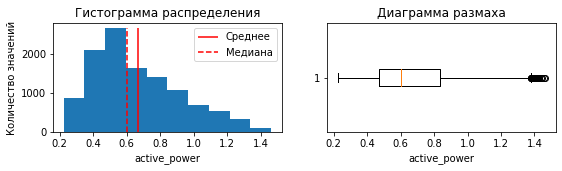

Статистический анализ показателя reactive_power
--------------------------------------------------------------------------------------------------------------


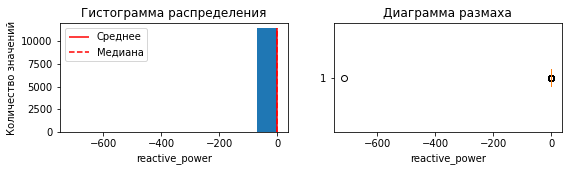

In [33]:
stat_plots(arc[['active_power', 'reactive_power']])

Обработаем выброс в поле reactive_power:

In [34]:
arc.query('key == 2116')

,key,heating_start,heating_stop,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [35]:
arc.iloc[9780, 4] /= (-1000)

Статистический анализ показателя reactive_power
--------------------------------------------------------------------------------------------------------------


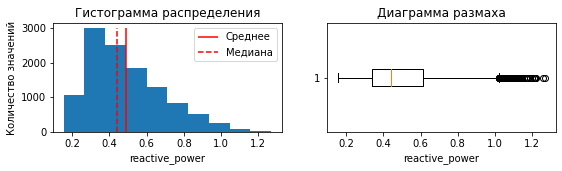

In [36]:
stat_plots(arc[['reactive_power']])

Статистический анализ показателя bulk_1
--------------------------------------------------------------------------------------------------------------


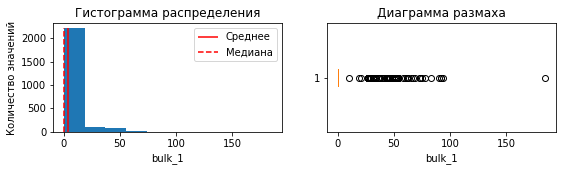

Статистический анализ показателя bulk_2
--------------------------------------------------------------------------------------------------------------


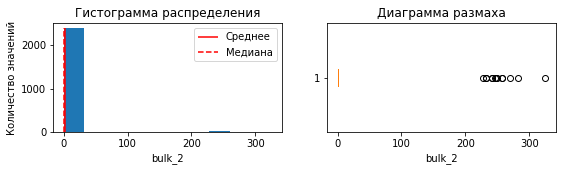

Статистический анализ показателя bulk_3
--------------------------------------------------------------------------------------------------------------


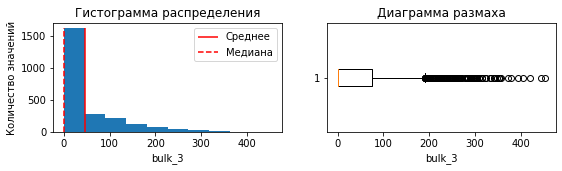

Статистический анализ показателя bulk_4
--------------------------------------------------------------------------------------------------------------


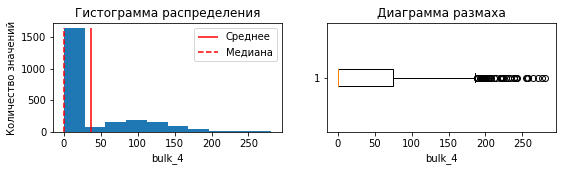

Статистический анализ показателя bulk_5
--------------------------------------------------------------------------------------------------------------


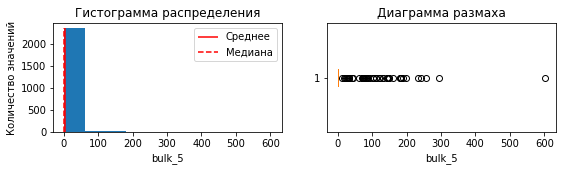

Статистический анализ показателя bulk_6
--------------------------------------------------------------------------------------------------------------


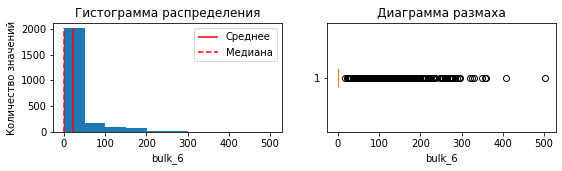

Статистический анализ показателя bulk_7
--------------------------------------------------------------------------------------------------------------


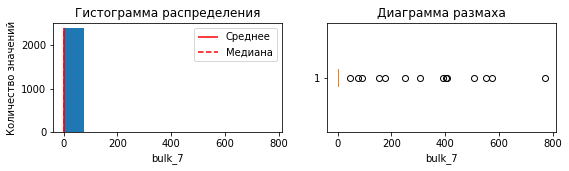

Статистический анализ показателя bulk_8
--------------------------------------------------------------------------------------------------------------


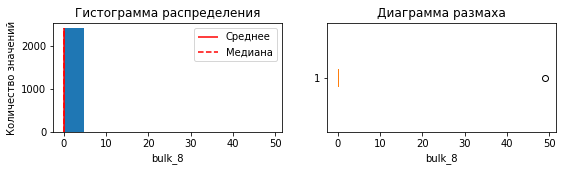

Статистический анализ показателя bulk_9
--------------------------------------------------------------------------------------------------------------


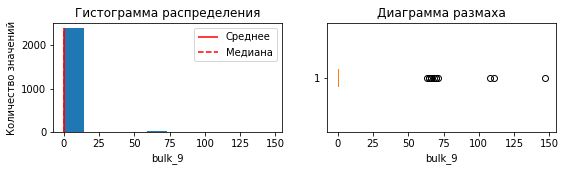

Статистический анализ показателя bulk_10
--------------------------------------------------------------------------------------------------------------


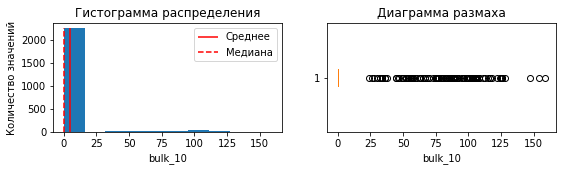

Статистический анализ показателя bulk_11
--------------------------------------------------------------------------------------------------------------


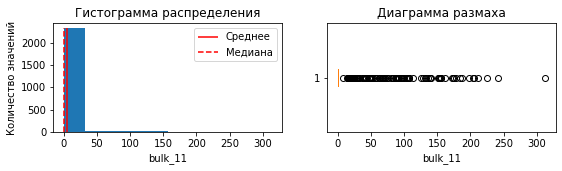

Статистический анализ показателя bulk_12
--------------------------------------------------------------------------------------------------------------


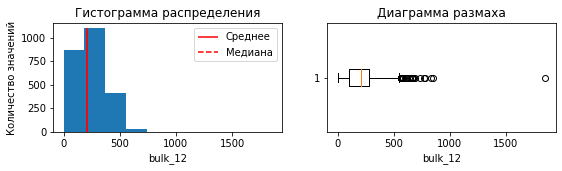

Статистический анализ показателя bulk_13
--------------------------------------------------------------------------------------------------------------


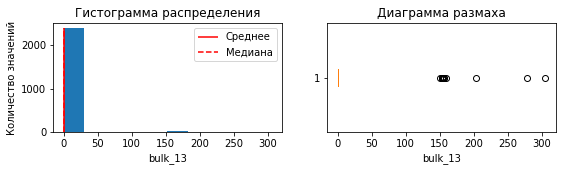

Статистический анализ показателя bulk_14
--------------------------------------------------------------------------------------------------------------


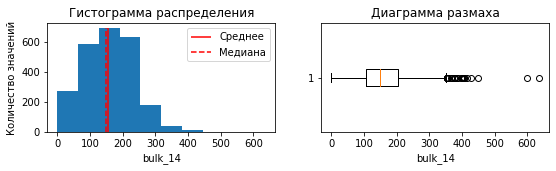

Статистический анализ показателя bulk_15
--------------------------------------------------------------------------------------------------------------


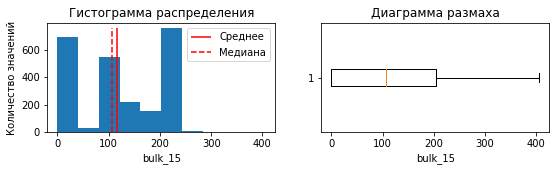

Статистический анализ показателя bulk_feeders
--------------------------------------------------------------------------------------------------------------


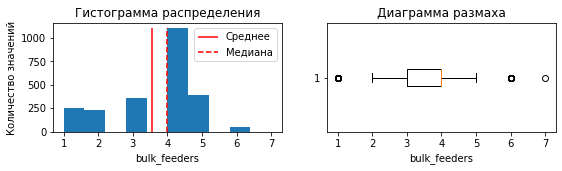

In [37]:
stat_plots(bulk.drop('key', axis=1).fillna(0))

Статистический анализ показателя wire_1
--------------------------------------------------------------------------------------------------------------


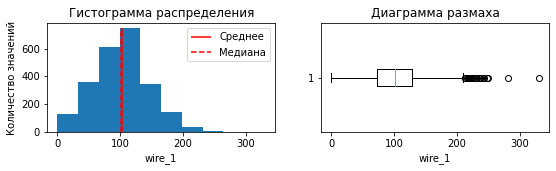

Статистический анализ показателя wire_2
--------------------------------------------------------------------------------------------------------------


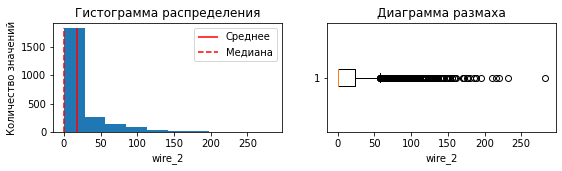

Статистический анализ показателя wire_3
--------------------------------------------------------------------------------------------------------------


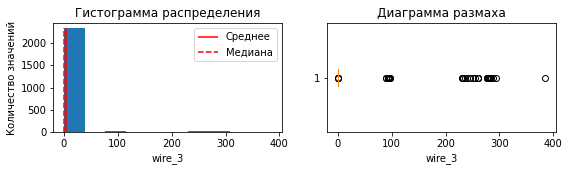

Статистический анализ показателя wire_4
--------------------------------------------------------------------------------------------------------------


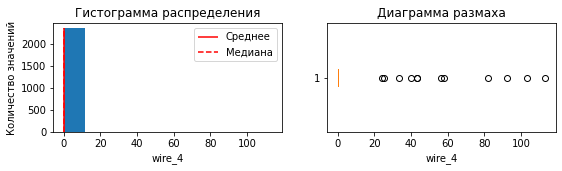

Статистический анализ показателя wire_5
--------------------------------------------------------------------------------------------------------------


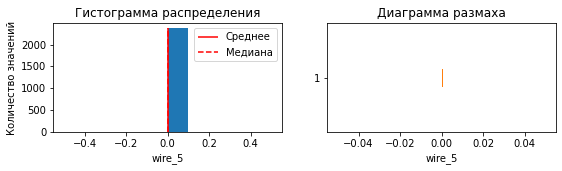

Статистический анализ показателя wire_6
--------------------------------------------------------------------------------------------------------------


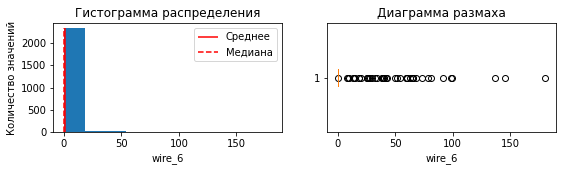

Статистический анализ показателя wire_7
--------------------------------------------------------------------------------------------------------------


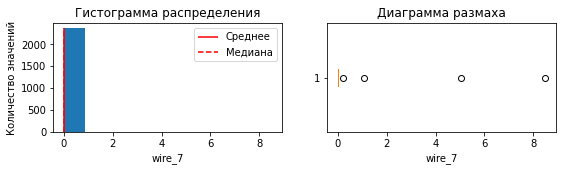

Статистический анализ показателя wire_8
--------------------------------------------------------------------------------------------------------------


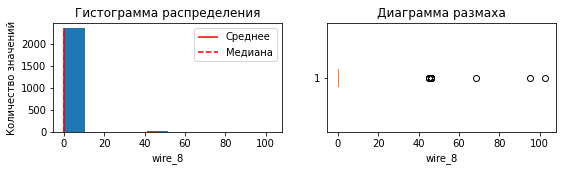

Статистический анализ показателя wire_9
--------------------------------------------------------------------------------------------------------------


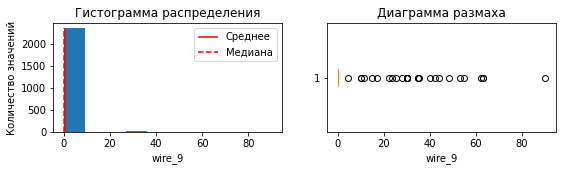

Статистический анализ показателя wire_feeders
--------------------------------------------------------------------------------------------------------------


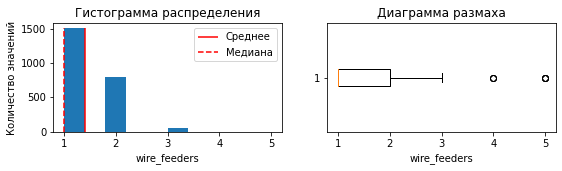

In [38]:
stat_plots(wire.drop('key', axis=1).fillna(0))

Статистический анализ показателя temperature
--------------------------------------------------------------------------------------------------------------


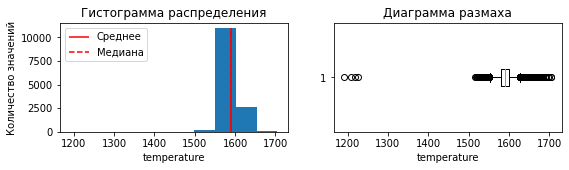

In [39]:
stat_plots(temp[['temperature']].dropna().reset_index(drop=True))

Согласно техпроцессу, выплавка стали производится при температуре свыше 1300 градусов.\
Удалим записи с меньшими температурами как аномалии:

In [40]:
temp = temp.drop(temp[temp['temperature'] < 1320].index, axis=0).reset_index(drop=True)

Статистический анализ показателя gas_volume
--------------------------------------------------------------------------------------------------------------


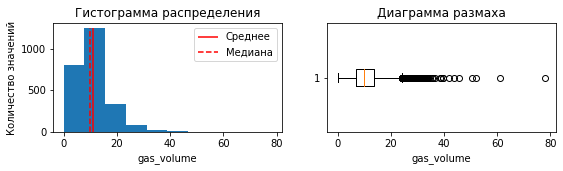

In [41]:
stat_plots(gas[['gas_volume']])

#### Промежуточный вывод

Данные имеют ненормальное распределение и большое количество выбросов.\
Среди выбросов также присутствуют аномалии, которые были устранены:
- отрицательное значение реактивной мощности
- значения замеров температуры, не соответствующие техпроцессу Заказчика

Статистические выбросы запланированы к устранению после объединения данных.\
В соответствии с требованиями Заказчика, из обучения были исключены все партии, для которых имеются данные менее чем о двух замерах температуры.

## Подготовка данных для обучения

### Объединение данных

Отберем данные о первом и последнем замерах температуры для каждой партии

In [42]:
temp = temp.pivot_table(index='key', values='temperature', aggfunc=['first', 'last'])
temp.columns = ['first_temp', 'last_temp']
temp.head(3)

,first_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0


Вычислим полную мощность

In [43]:
arc['full_power'] = (arc['active_power']**2 + arc['reactive_power']**2)**0.5

Вычислим время нагрева для каждой сессии

In [44]:
arc['heating_time'] = pd.to_numeric(
    (arc['heating_stop'] - arc['heating_start'])
    .dt.seconds, downcast='integer')

Суммируем показатели нагрева по партиям

In [45]:
arc = arc.pivot_table(index='key', values=['full_power', 'heating_time', 'active_power', 'reactive_power'], aggfunc='sum')
arc.head(5)

,active_power,full_power,heating_time,reactive_power
key,,,,
1,3.036730,3.718736,1098,2.142821
2,2.139408,2.588349,811,1.453357
3,4.063641,5.019223,655,2.937457
4,2.706489,3.400038,741,2.056992
5,2.252950,2.816980,869,1.687991


Построим общий датасет на основе данных о замерах температуры

In [46]:
data = temp.merge(arc, on='key', how='inner')
data.head(5)

,first_temp,last_temp,active_power,full_power,heating_time,reactive_power
key,,,,,,
1,1571.0,1613.0,3.036730,3.718736,1098,2.142821
2,1581.0,1602.0,2.139408,2.588349,811,1.453357
3,1596.0,1599.0,4.063641,5.019223,655,2.937457
4,1601.0,1625.0,2.706489,3.400038,741,2.056992
5,1576.0,1602.0,2.252950,2.816980,869,1.687991


Вычислим суммарный объем подачи сыпучих материалов по партиям

In [47]:
bulk['bulk_feed'] = bulk[bulk.columns[1:-1]].sum(axis=1)

In [48]:
bulk = bulk[['key', 'bulk_feed', 'bulk_feeders']]

Присоединим данные о подаче сыпучих материалов к общему датасету

In [49]:
data = data.merge(bulk, on='key', how='inner')
data.head(5)

,key,first_temp,last_temp,active_power,full_power,heating_time,reactive_power,bulk_feed,bulk_feeders
0,1,1571.0,1613.0,3.036730,3.718736,1098,2.142821,553.0,4
1,2,1581.0,1602.0,2.139408,2.588349,811,1.453357,582.0,4
2,3,1596.0,1599.0,4.063641,5.019223,655,2.937457,544.0,4
3,4,1601.0,1625.0,2.706489,3.400038,741,2.056992,595.0,4
4,5,1576.0,1602.0,2.252950,2.816980,869,1.687991,584.0,4


Вычислим суммарный объем подачи проволоки по партиям

In [50]:
wire['wire_feed'] = wire[wire.columns[1:-1]].sum(axis=1)

In [51]:
wire = wire[['key', 'wire_feed', 'wire_feeders']]

Присоединим данные о подаче проволоки к общему датасету

In [52]:
data = data.merge(wire, on='key', how='inner')
data.head(5)

,key,first_temp,last_temp,active_power,full_power,heating_time,reactive_power,bulk_feed,bulk_feeders,wire_feed,wire_feeders
0,1,1571.0,1613.0,3.036730,3.718736,1098,2.142821,553.0,4,60.059998,1
1,2,1581.0,1602.0,2.139408,2.588349,811,1.453357,582.0,4,96.052315,1
2,3,1596.0,1599.0,4.063641,5.019223,655,2.937457,544.0,4,91.160157,1
3,4,1601.0,1625.0,2.706489,3.400038,741,2.056992,595.0,4,89.063515,1
4,5,1576.0,1602.0,2.252950,2.816980,869,1.687991,584.0,4,98.352796,2


Присоединим данные о продувке газом к общему датасету

In [53]:
data = data.merge(gas, on='key', how='inner')
data.head(5)

,key,first_temp,last_temp,active_power,full_power,heating_time,reactive_power,bulk_feed,bulk_feeders,wire_feed,wire_feeders,gas_volume
0,1,1571.0,1613.0,3.036730,3.718736,1098,2.142821,553.0,4,60.059998,1,29.749986
1,2,1581.0,1602.0,2.139408,2.588349,811,1.453357,582.0,4,96.052315,1,12.555561
2,3,1596.0,1599.0,4.063641,5.019223,655,2.937457,544.0,4,91.160157,1,28.554793
3,4,1601.0,1625.0,2.706489,3.400038,741,2.056992,595.0,4,89.063515,1,18.841219
4,5,1576.0,1602.0,2.252950,2.816980,869,1.687991,584.0,4,98.352796,2,5.413692


Изучим полученный датасет

In [54]:
data_report(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2329 non-null   int64  
 1   first_temp      2329 non-null   float64
 2   last_temp       2329 non-null   float64
 3   active_power    2329 non-null   float64
 4   full_power      2329 non-null   float64
 5   heating_time    2329 non-null   int16  
 6   reactive_power  2329 non-null   float64
 7   bulk_feed       2329 non-null   float64
 8   bulk_feeders    2329 non-null   int64  
 9   wire_feed       2329 non-null   float64
 10  wire_feeders    2329 non-null   int64  
 11  gas_volume      2329 non-null   float64
dtypes: float64(8), int16(1), int64(3)
memory usage: 222.9 KB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и нулевыми значениями: 0
-------------------------------------------------------------

Поскольку данные о времени подачи проволоки и сыпучих материалов потеряли свой смысл после суммирования объемов, присоединять их не будем.

Приведем в соответствие типы данных

In [55]:
data = data.astype('float16')
data['key'] = data.key.astype('int16')
data['first_temp'] = data.first_temp.astype('int16')
data['last_temp'] = data.last_temp.astype('int16')
data['heating_time'] = data.heating_time.astype('int16')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2329 non-null   int16  
 1   first_temp      2329 non-null   int16  
 2   last_temp       2329 non-null   int16  
 3   active_power    2329 non-null   float16
 4   full_power      2329 non-null   float16
 5   heating_time    2329 non-null   int16  
 6   reactive_power  2329 non-null   float16
 7   bulk_feed       2329 non-null   float16
 8   bulk_feeders    2329 non-null   float16
 9   wire_feed       2329 non-null   float16
 10  wire_feeders    2329 non-null   float16
 11  gas_volume      2329 non-null   float16
dtypes: float16(8), int16(4)
memory usage: 72.8 KB


Выведем номер партии в индекс

In [57]:
data = data.set_index('key')

### Исследовательский анализ объединенных данных

Cформируем обучающий и тестовый датасеты:

In [58]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

Статистический анализ показателя first_temp
--------------------------------------------------------------------------------------------------------------


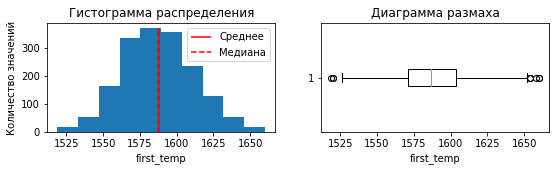

Статистический анализ показателя last_temp
--------------------------------------------------------------------------------------------------------------


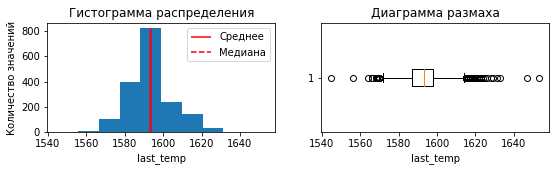

Статистический анализ показателя active_power
--------------------------------------------------------------------------------------------------------------


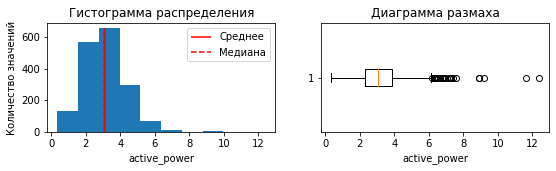

Статистический анализ показателя full_power
--------------------------------------------------------------------------------------------------------------


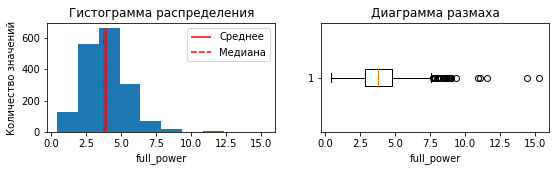

Статистический анализ показателя heating_time
--------------------------------------------------------------------------------------------------------------


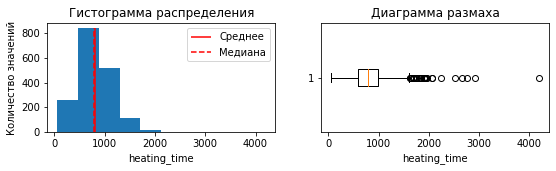

Статистический анализ показателя reactive_power
--------------------------------------------------------------------------------------------------------------


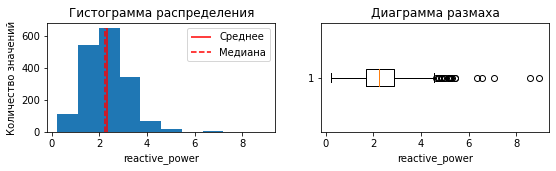

Статистический анализ показателя bulk_feed
--------------------------------------------------------------------------------------------------------------


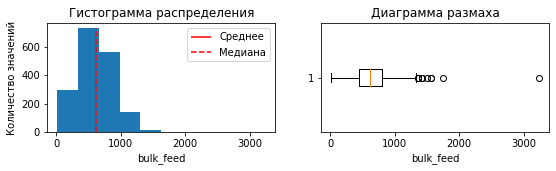

Статистический анализ показателя bulk_feeders
--------------------------------------------------------------------------------------------------------------


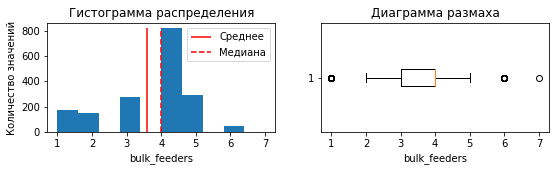

Статистический анализ показателя wire_feed
--------------------------------------------------------------------------------------------------------------


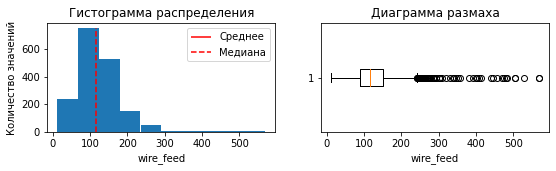

Статистический анализ показателя wire_feeders
--------------------------------------------------------------------------------------------------------------


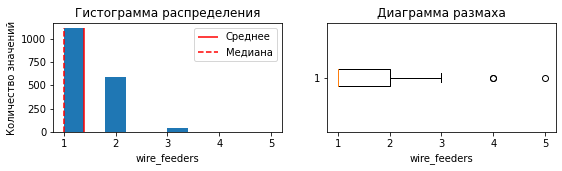

Статистический анализ показателя gas_volume
--------------------------------------------------------------------------------------------------------------


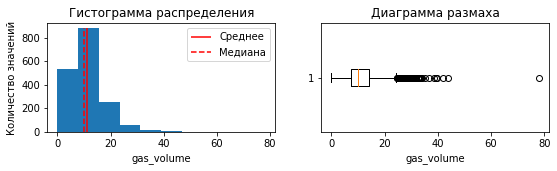

In [59]:
warnings.filterwarnings('ignore')
stat_plots(train_data)

TBD

### Корректировка данных

Зададим границы статистических выбросов для всех параметров, как полуторное межквартильное расстояние:

In [60]:
stats = pd.DataFrame(train_data.describe()).T
stats['top_margin'] = stats['50%'] + (stats['75%'] - stats['50%']) * 1.5
stats['bottom_margin'] = stats['25%'] - (stats['50%'] - stats['25%']) * 1.5
stats

,count,mean,std,min,25%,50%,75%,max,top_margin,bottom_margin
first_temp,1746.0,1587.705040,23.954435,1519.000000,1571.000000,1587.000000,1604.000000,1660.000000,1612.500000,1547.000000
last_temp,1746.0,1593.559565,11.141505,1545.000000,1587.000000,1593.000000,1598.000000,1653.000000,1600.500000,1578.000000
active_power,1746.0,3.136719,1.227539,0.356689,2.305664,3.037109,3.845215,12.375000,4.249268,1.208496
full_power,1746.0,3.898438,1.525391,0.427734,2.857910,3.779297,4.795898,15.289062,5.304199,1.475830
heating_time,1746.0,810.993127,342.833979,61.000000,583.000000,783.000000,996.750000,4188.000000,1103.625000,283.000000
reactive_power,1746.0,2.308594,0.907227,0.235962,1.680908,2.230469,2.849121,8.945312,3.158447,0.856567
bulk_feed,1746.0,inf,inf,19.000000,443.000000,611.000000,801.500000,3236.000000,896.750000,191.000000
bulk_feeders,1746.0,3.597656,1.218750,1.000000,3.000000,4.000000,4.000000,7.000000,4.000000,1.500000
wire_feed,1746.0,inf,inf,12.976562,90.000000,116.000000,151.125000,569.000000,168.687500,51.000000
wire_feeders,1746.0,1.388672,0.546387,1.000000,1.000000,1.000000,2.000000,5.000000,2.500000,1.000000


Удалим все статистические выбросы из тренировочных данных:

In [61]:
cut_list = stats.index[[3]]
for par in cut_list:
    train_data = train_data.drop(train_data[train_data[par] > stats.loc[par, 'top_margin']].index, axis=0)
    train_data = train_data.drop(train_data[train_data[par] < stats.loc[par, 'bottom_margin']].index, axis=0)
    train_data = train_data.reset_index(drop=True)

**Выделим целевой признак**

In [62]:
X_train, y_train = train_data.drop('last_temp', axis=1), train_data['last_temp']
X_test, y_test = test_data.drop('last_temp', axis=1), test_data['last_temp']

### Анализ корреляций

Данные распределены ненормально, поэтому будем использовать корреляцию PhiK 

interval columns not set, guessing: ['first_temp', 'last_temp', 'active_power', 'full_power', 'heating_time', 'reactive_power', 'bulk_feed', 'bulk_feeders', 'wire_feed', 'wire_feeders', 'gas_volume']


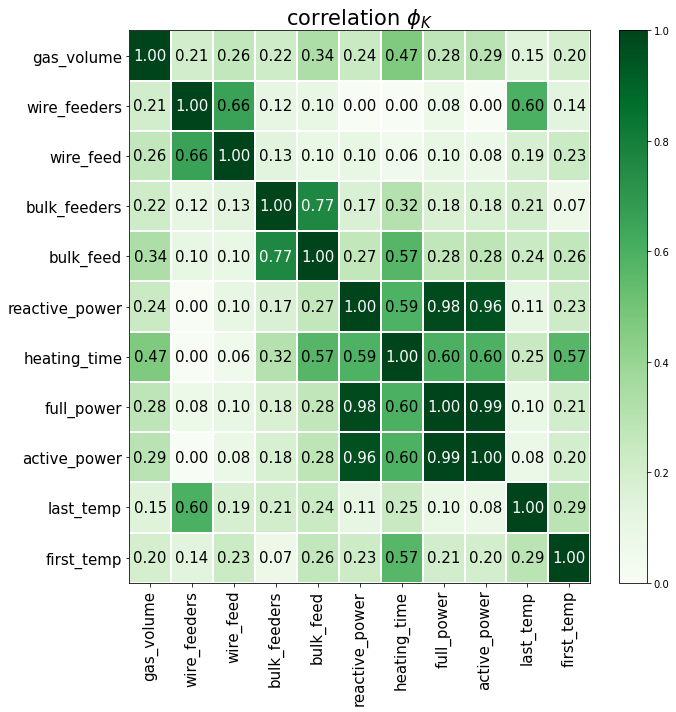

In [63]:
phik_overview = phik_matrix(train_data)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

### Промежуточный вывод

В рамках формирования общего датасета были произведены следующие операции:
- выделены первый и последний замеры температуры
- введен дополнительный вычисляемый признак Полная Мощность (full_power)
- вычислен суммарный объем загрузки балласта и проволочных материалов
- типы данных приведены к ресурсосберегающим форматам
- номер партии выведен в индекс

В соответствии с требованиями Заказчика в общий датасет были объединены только партии, которые присутствуют во всех источниках.\

Исследовательский анализ объединенного датасета показал наличие статистических выбросов некоторых признаков.\
Экспериментальным путем, во избежание переобучения моделей, для очистки от выбросов были определены следующие признаки:
- full_power (полная мощность на электродах)
- wire_feed (суммарный объем загрузки проволоки)

Объединенный датасет был разделен на тренировочную и тестовую выборки. Выбросы были удалены только из тренировочной выборки для эмуляции боевого режима работы моделей.

## Построение пайплайна

In [64]:
pipe_train =  Pipeline([
    ('scaler', 'passthrough'),
    ('models', 'passthrough')
])

In [65]:
param_lr = [
    {
        'models': [LinearRegression()],
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    }
]

In [66]:
param_dt = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 50),
        'models__min_samples_leaf': range(2, 50),
        'models__max_depth': range(2, 50),
        'models__max_features': range(2, 50),
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    }
]

In [67]:
param_knn = [
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 50),
        'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    }
]

In [68]:
param_lgb = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate': np.arange(0.01, 0.1, 0.01),
        'models__n_estimators': range(100, 1000, 50),
        'models__max_depth': range(2, 5),
        'models__num_leaves': range(4, 20),
        'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()]
    } 
]

In [69]:
cv_test_lr = RandomizedSearchCV(
    pipe_train,
    param_lr,
    n_jobs=-1,
    cv=5,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE
)

In [70]:
cv_test_dt = RandomizedSearchCV(
    pipe_train,
    param_dt,
    n_jobs=-1,
    cv=5,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE
)

In [71]:
cv_test_knn = RandomizedSearchCV(
    pipe_train,
    param_knn,
    n_jobs=-1,
    cv=5,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE
)

In [72]:
cv_test_lgb = RandomizedSearchCV(
    pipe_train,
    param_lgb,
    n_jobs=-1,
    cv=5,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE
)

## Контроль адекватности

In [73]:
dr = DummyRegressor(constant=1500)
dr.fit(X_train, y_train)
y_pred_dummy = dr.predict(X_test)
dummy_mae = mean_absolute_error(y_test, y_pred_dummy)
print(f'Ошибка MAE константной модели - {round(dummy_mae, 1)}')

Ошибка MAE константной модели - 8.0


## Обучение моделей

In [74]:
models = [cv_test_lr, cv_test_dt, cv_test_knn, cv_test_lgb]

warnings.filterwarnings('ignore')
for i in range(0, 4):
    model = models[i]
    model.fit(X_train, y_train)
    pd.set_option('display.max_colwidth', None)
    result = pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score')
    display(result[['mean_test_score', 'param_scaler', 'params']].head(3))

,mean_test_score,param_scaler,params
1,-6.594585,MinMaxScaler(),"{'scaler': MinMaxScaler(), 'models': LinearRegression()}"
0,-6.594586,StandardScaler(),"{'scaler': StandardScaler(), 'models': LinearRegression()}"
2,-6.594586,RobustScaler(),"{'scaler': RobustScaler(), 'models': LinearRegression()}"


,mean_test_score,param_scaler,params
16,-6.995219,StandardScaler(),"{'scaler': StandardScaler(), 'models__min_samples_split': 33, 'models__min_samples_leaf': 12, 'models__max_features': 37, 'models__max_depth': 43, 'models': DecisionTreeRegressor(random_state=280725)}"
4,-6.997925,MinMaxScaler(),"{'scaler': MinMaxScaler(), 'models__min_samples_split': 48, 'models__min_samples_leaf': 20, 'models__max_features': 35, 'models__max_depth': 23, 'models': DecisionTreeRegressor(random_state=280725)}"
7,-7.006826,MinMaxScaler(),"{'scaler': MinMaxScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 20, 'models__max_features': 40, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=280725)}"


,mean_test_score,param_scaler,params
10,-6.783120,StandardScaler(),"{'scaler': StandardScaler(), 'models__n_neighbors': 12, 'models': KNeighborsRegressor()}"
19,-6.787781,StandardScaler(),"{'scaler': StandardScaler(), 'models__n_neighbors': 13, 'models': KNeighborsRegressor()}"
42,-6.795973,StandardScaler(),"{'scaler': StandardScaler(), 'models__n_neighbors': 20, 'models': KNeighborsRegressor()}"


,mean_test_score,param_scaler,params
6,-6.318386,StandardScaler(),"{'scaler': StandardScaler(), 'models__num_leaves': 17, 'models__n_estimators': 950, 'models__max_depth': 3, 'models__learning_rate': 0.01, 'models': LGBMRegressor(random_state=280725)}"
9,-6.368303,RobustScaler(),"{'scaler': RobustScaler(), 'models__num_leaves': 4, 'models__n_estimators': 350, 'models__max_depth': 3, 'models__learning_rate': 0.060000000000000005, 'models': LGBMRegressor(random_state=280725)}"
5,-6.449742,RobustScaler(),"{'scaler': RobustScaler(), 'models__num_leaves': 15, 'models__n_estimators': 650, 'models__max_depth': 2, 'models__learning_rate': 0.060000000000000005, 'models': LGBMRegressor(random_state=280725)}"


## Тестирование моделей

Минимальное значение целевой метрики на кросс-валидации показала следующая модель:

In [75]:
print(models[3].best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('models',
                 LGBMRegressor(learning_rate=0.01, max_depth=3,
                               n_estimators=950, num_leaves=17,
                               random_state=280725))])


Выполним для этой модели расчет целевой метрики на тестовом датасете:

In [76]:
warnings.filterwarnings('ignore')
best_suite = Pipeline(steps=[('scaler', StandardScaler()),
                ('models',
                 LGBMRegressor(learning_rate=0.01, max_depth=3,
                               n_estimators=950, num_leaves=17,
                               random_state=280725))])
best_suite.fit(X_train, y_train)
y_pred = best_suite.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Ошибка MAE лучшей модели на тестовой выборке - {round(mae, 2)}')

Ошибка MAE лучшей модели на тестовой выборке - 6.76


Целевое значение метрики достигнуто, модель может быть рекомендована Заказчику.

Исследуем значимость признаков:

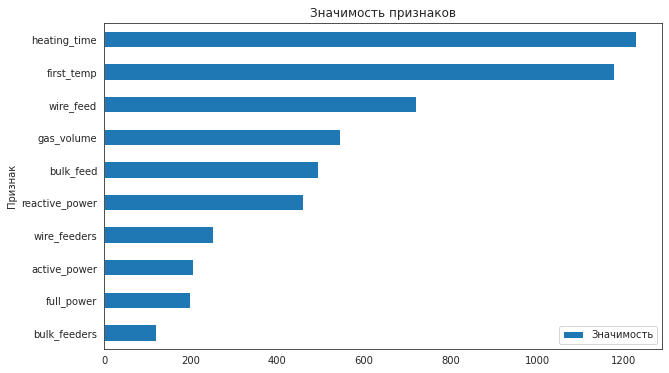

In [77]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
model = LGBMRegressor(learning_rate=0.01, max_depth=3,
                               n_estimators=950, num_leaves=17,
                               random_state=280725)
model.fit(X_train_scaled, y_train)
coefficients = model.feature_importances_
features_names = X_train.columns
feature_importance = pd.DataFrame({'Признак': features_names, 'Значимость': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Значимость', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Признак', y='Значимость', kind='barh', figsize=(10, 6))
plt.title('Значимость признаков')
plt.show()

## Итоговый вывод

По результатам выполнения проекта, наилучшие результаты на кросс-валидации показала модель градиентного бустинга LGBMRegressor, со следующими настройками гиперпараметров:
- learning_rate=0.01
- max_depth=3
- n_estimators=950
- num_leaves=17
- random_state=280725
- масштабирование StandardScaler

В сравнении примали участие следующие альтернатичные модели:
- Линейная регрессия
- Дерево решений
- Метод ближайших соседей

Наибольшую значимость для прогнозирования результатов продемонстрировали признаки:
- Первый замер температуры (first_temp)
- Время работы электрода нагрева (heating_time)
- Объем загрузки проволочных материалов (wire_feed)
- Объем инертного газа для прокачки сплава (gas_feed)

Наименьшее влияние на результат прогнозирования показали признаки:
- Активная мощность (active_power)
- Полная мощность (full_power)
- Количество загрузок балласта (bulk_feeders)
- Количество загрузок проволоки (wire_feeders)

**Рекомендации бизнесу**

Для достижения экономии энергоресурсов в процессе выплавки стали, рекомендуется:
1. Поддерживать стабильную температуру исходного сырья
2. Координировать период нагрева с объемом загрузки проволочных материалов
3. Координировать продувку инертным газом с нагревом и загрузкой лигатуры для устранения перегрева сплава
4. Балансировать процесс нагрева сплава в сторону увеличения продолжительности нагрева и снижения подаваемой мощности
5. Для планирования вышеуказанных показетелй техпроцесса использовать модель LGBMRegressor с рекомендованными выше настройками. 